In [1]:
import itertools
import numpy as np
import os
import random
import time
import matplotlib.pyplot as plt
import matplotlib.animation
import subprocess
from sympy import *
from sympy.solvers import solve
from sympy.solvers import nsolve
from sympy import Symbol
from tqdm import tqdm

In [2]:
%matplotlib inline

Simple gridworld example (no ML libraries)
========

# Introduction
* In reinforcement learning the agent moves around influencing the environment it finds itself in with the actions it can take, which in turn affects the subsequent data it receives.
* Reinforcement learning does not train on a static set of data. It works on a dynamic system where time matters.
* You see how the decisions unfold over time.
* The agent is solely influenced by a reward signal.

## Agent and reward
The **reward hypothesis** states that all goals can be described by the maximization of expected cumulative reward.
* **Reward**: scalar feedback signal, a number $R_t$ (any number). The cumulative reward indicates how well the agent is doing at step $t$.
* **Goal**: select actions to maximize total future cumulative reward.

# Defining the gridworld environment
A **"gridworld"** is a common reinforcement learning example due to its simplicity. It just consists of a 2D grid where the agent can move. 
Let's consider 4 actions:

\begin{equation}
    \mathcal{A} = [\text{up, down, right, left}]
\end{equation}

where $\mathcal{A}$ a finite set of actions.

In [3]:
# For now this is just a couple of strings. They will take their meaning further down with the "step" function.
actions = ["up", "down", "left", "right"]

## Reward in the gridworld example

The goal of the agent is to get from the **start state** to the **stop state** as fast as possible. 


* The reward of any state (except for the stop state) will be -1. 
    * If the reward is positive in every step, the agent would just randomly walk accumulating reward. With a negative reward it penalizes every step not taken in the right direction. 
* The final state has a reward of 1.
* In order to create a single fastest path and reduce the complexity of the system, we can position blocks in our grid.

In [4]:
reward_normal = -1
reward_stop = 1


def get_reward(state):
    if state == stop:
        return reward_stop
    else:
        return reward_normal

# Create your gridworld
Write below the dimensions of the gridworld and the position of the blocks. You will see it plotted in the "state grid" section below.

In [5]:
# INPUT FROM USER
# ---------------

rows = 4
columns = 4

# blocks = [13, 14, 15, 24, 25, 2, 3, 23]
blocks = [2, 9, 11, 13]  # 4x4

In [6]:
# The agent will start in state "0" and will consider the episode is over when it reaches the last state.
start = 0
stop = rows * columns - 1

In [7]:
def plot_gridworld(rows, columns, blocks, labels):
    counter_columns = -1
    counter_rows = 0

    row_grid_color = []
    all_states_grid_color = np.zeros([rows, columns])

    row_grid = []
    all_states_grid = np.zeros([rows, columns], dtype=int)

    row_grid_reward = []
    all_states_grid_reward = np.zeros([rows, columns], dtype=int)

    for s in range(0, rows * columns):
        counter_columns += 1
        if counter_columns < columns - 1:
            row_grid.append(s)
            if s in blocks:
                row_grid_color.append(0)
                row_grid_reward.append(66)
            else:
                row_grid_reward.append(get_reward(s))
                row_grid_color.append(0.5)
        else:
            row_grid.append(s)
            if s in blocks:
                row_grid_color.append(0)
                row_grid_reward.append(66)
            else:
                row_grid_reward.append(get_reward(s))
                row_grid_color.append(0.5)

            all_states_grid[counter_rows] = row_grid
            all_states_grid_color[counter_rows] = row_grid_color
            all_states_grid_reward[counter_rows] = row_grid_reward

            row_grid = []
            row_grid_color = []
            row_grid_reward = []

            counter_columns = -1
            counter_rows += 1

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.imshow(
        all_states_grid_color,
        extent=[0, columns, rows, 0],
        cmap="viridis",
        vmin=0,
        vmax=1,
    )

    ax.grid(color="black", linestyle="-", linewidth=5)
    ax.xaxis.set_ticklabels([])
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks_position("none")

    ax.set_xticks(np.arange(0, columns, step=1))
    ax.set_yticks(np.arange(0, rows, step=1))

    if labels == "states":
        for i in range(0, rows):
            for j in range(0, columns):
                text = ax.text(
                    j + 0.15,
                    i + 0.15,
                    all_states_grid[i, j],
                    ha="left",
                    va="top",
                    color="w",
                    size=15,
                )
    elif labels == "rewards":
        for i in range(0, rows):
            for j in range(0, columns):
                if all_states_grid_reward[i, j] != 66:
                    text = ax.text(
                        j + 0.4,
                        i + 0.4,
                        all_states_grid_reward[i, j],
                        ha="left",
                        va="top",
                        color="w",
                        size=15,
                    )
    plt.show()
    return all_states_grid

## Available states

In [8]:
def get_states(rows, columns, blocks):
    states = list(np.linspace(0, rows * columns - 1, rows * columns))
    for b in blocks:
        states.remove(b)
    return states

In [9]:
states = get_states(rows, columns, blocks)
print("S =", states)

S = [np.float64(0.0), np.float64(1.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(10.0), np.float64(12.0), np.float64(14.0), np.float64(15.0)]


## State grid

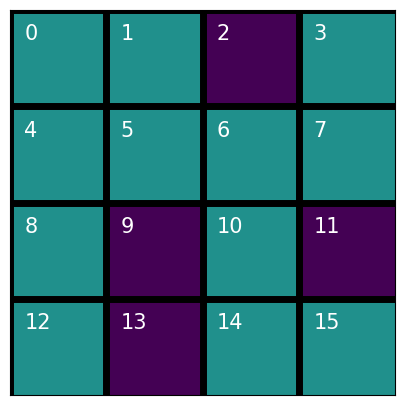

In [10]:
# Run this cell to automatically generate the gridworld with the correspondent states and blocks
all_states_grid = plot_gridworld(rows, columns, blocks, "states")

## Reward grid

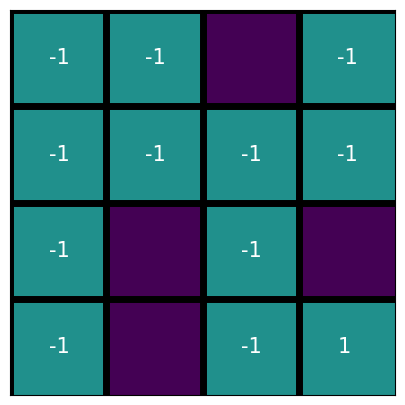

In [11]:
# Run this cell to automatically generate the gridworld with the correspondent rewards
all_states_grid = plot_gridworld(rows, columns, blocks, "rewards")

## Environment

In [12]:
# Functions that define the environment
# https://stackoverflow.com/questions/48135736/what-is-an-intuitive-explanation-of-np-unravel-index


def get_key(my_dict, val):
    for key, value in my_dict.items():
        if val == value:
            return key

    return "key doesn't exist"


def get_grid_indices(rows, columns):
    indices = []
    for r in range(0, rows):
        for c in range(0, columns):
            indices.append((r, c))
    state_index = {}
    for s, i in enumerate(indices):
        state_index[s] = i
    return state_index


def step(state, action, state_index, all_states_grid):
    if action == "up":  # if you want to move up
        if state in all_states_grid[0]:  # and you are in the top row
            new_state_index = (
                state_index[state][0],
                state_index[state][1],
            )  # you stay where you are
        else:
            new_state_index = (state_index[state][0] - 1, state_index[state][1])

    elif action == "down":  # if you want to move down
        if state in all_states_grid[rows - 1]:  # and you are in the bottom row
            new_state_index = (
                state_index[state][0],
                state_index[state][1],
            )  # you stay where you are
        else:
            new_state_index = (state_index[state][0] + 1, state_index[state][1])

    elif action == "right":  # if you want to move right
        if state in all_states_grid[:, columns - 1]:  # and you are in the right column
            new_state_index = (
                state_index[state][0],
                state_index[state][1],
            )  # you stay where you are
        else:
            new_state_index = (state_index[state][0], state_index[state][1] + 1)

    elif action == "left":  # if you want to move left
        if state in all_states_grid[:, 0]:  # and you are in the left column
            new_state_index = (
                state_index[state][0],
                state_index[state][1],
            )  # you stay where you are
        else:
            new_state_index = (state_index[state][0], state_index[state][1] - 1)

    new_state = get_key(state_index, new_state_index)

    if new_state in blocks:
        new_state = state

    return new_state

* We mapped each numerical state to a matrix notation form to apply the actions in an easier way:

In [13]:
state_index = get_grid_indices(rows, columns)
print(state_index)

{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (0, 3), 4: (1, 0), 5: (1, 1), 6: (1, 2), 7: (1, 3), 8: (2, 0), 9: (2, 1), 10: (2, 2), 11: (2, 3), 12: (3, 0), 13: (3, 1), 14: (3, 2), 15: (3, 3)}


* We embedded the gridworld limits and blocks into the "step" function:

In [14]:
print(step(stop, "right", state_index, all_states_grid))

15


# Policy
A policy $\pi$ defines how the agent picks its actions, how it will take exploratory decisions. In other words: 
* It's a mapping from states to probabilities of selecting each possible action.
* It's the probability of taking a specific action $a$ by being in a specific state $s$ is given by the policy $\pi$.

\begin{equation}
    \pi(a|s) = \mathbb{P}[\mathcal{A_t}=a|\mathcal{S_t}=s]
\end{equation}

In this case we will choose a stochastic equiprobable policy, i.e. there is the same probabilty that the agent will take any of the actions for any state.

In [15]:
def get_policy(actions):
    policy = {}
    for a in actions:
        policy[a] = 1 / len(actions)
    return policy

In [16]:
policy = get_policy(actions)
print(policy)

{'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25}


# Observing an agent following an equiprobable random policy
## One episode
If we make the agent follow the equiprobable random policy defined above in a 4x4 gridworld, a random episode would look like the animation shown below. You can see that this policy is very inefficient, since the minimum number of steps to reach the final state (6 steps) is much lower than following an equiprobable policy. The good part is that it can be easily improved upon.
* In the example we are tackling the cumulated reward will be equal to the number of steps - 1 (because of the final reward of +1 in the final state), times -1

![](images/RandomAgent4x4.gif)

In [17]:
# Functions to explore the environment
def plot_gridworld_and_agent(
    rows, columns, blocks, state, fig, ax, steps, reward, save="no"
):
    counter_columns = -1
    counter_rows = 0

    row_grid_color = []
    all_states_grid_color = np.zeros([rows, columns])

    row_grid = []
    all_states_grid = np.zeros([rows, columns], dtype=int)

    # Getting the data
    for s in range(0, rows * columns):
        counter_columns += 1
        if counter_columns < columns - 1:
            row_grid.append(s)
            if s in blocks:
                row_grid_color.append(0)
            elif s == state:
                row_grid_color.append(1)
            else:
                row_grid_color.append(0.5)
        else:
            row_grid.append(s)
            if s in blocks:
                row_grid_color.append(0)
            elif s == state:
                row_grid_color.append(1)
            else:
                row_grid_color.append(0.5)

            all_states_grid[counter_rows] = row_grid
            all_states_grid_color[counter_rows] = row_grid_color

            row_grid = []
            row_grid_color = []

            counter_columns = -1
            counter_rows += 1

    # Plotting the data
    ax.imshow(
        all_states_grid_color,
        extent=[0, columns, rows, 0],
        cmap="viridis",
        vmin=0,
        vmax=1,
    )

    ax.grid(color="black", linestyle="-", linewidth=5)
    ax.xaxis.set_ticklabels([])
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks_position("none")

    ax.set_xticks(np.arange(0, columns, step=1))
    ax.set_yticks(np.arange(0, rows, step=1))

    ax.set_title("Random policy       Steps=" + str(steps), fontsize=14)

    for i in range(0, rows):
        for j in range(0, columns):
            text = ax.text(
                j + 0.15,
                i + 0.15,
                all_states_grid[i, j],
                ha="left",
                va="top",
                color="w",
                size=15,
            )

    fig.canvas.draw()

    if save == "yes":

        #         To save the file and convert it to GIF ----------------------------

        if len(str(steps)) == 1:
            steps = "00" + str(steps)
        elif len(str(steps)) == 2:
            steps = "0" + str(steps)

        filename = "RandomPolicyAgent_" + str(steps) + ".png"

        if os.path.exists(filename):
            os.remove(filename)

        plt.tight_layout()
        #         plt.subplots_adjust(right=0.85)
        plt.savefig(filename, bbox="tight")


#         convert -delay 10 -loop 0 Random*png RandomAgent.gif

#         --------------------------------------------------------------------


def take_step_finite(state, number_steps, state_index, all_states_grid):
    reward = get_reward(state)
    print(
        "{0:<15} {1:<15} {2:<15} {3:<15}".format(
            "State", "Action", "New State", "Cumulated Reward"
        )
    )
    print("-----------------------------------------------------------------")
    for st in range(1, number_steps + 1):
        action = np.random.choice(
            actions, p=[policy[actions[i]] for i in range(0, len(actions))]
        )
        new_state = step(state, action, state_index, all_states_grid)
        reward += get_reward(new_state)
        print(
            "{0:<15} {1:<15} {2:<15} {3:<15}".format(state, action, new_state, reward)
        )
        state = new_state


def take_one_step(state, state_index, all_states_grid):
    action = np.random.choice(
        actions, p=[policy[actions[i]] for i in range(0, len(actions))]
    )
    new_state = step(state, action, state_index, all_states_grid)
    reward = get_reward(new_state)

    #     reward += get_reward(new_state)
    return state, action, new_state, reward


def random_exploration(start, stop, state_index, length=0, save="no"):
    steps = 0
    reward_tot = get_reward(start)
    state = start

    fig, ax = plt.subplots(figsize=(7, 5))

    while state != stop:
        old_state, action, new_state, reward = take_one_step(
            state, state_index, all_states_grid
        )
        steps += 1
        reward_tot += reward
        plot_gridworld_and_agent(
            rows, columns, blocks, state, fig, ax, steps, reward_tot, save
        )
        state = new_state
        #         time.sleep(0.1)

        if length != 0:
            if steps >= length:
                break

    print(" ")
    print("This episode took", steps, "steps, with", reward_tot, "of reward")

    if save == "yes":
        subprocess.call(
            ["convert", "-delay", "10", "-loop", "0", "Random*png", "RandomAgent.gif"]
        )

## Try the function yourself in your gridworld
* Run the next cell to see how far the agent gets in 30 steps by randomly exploring the gridworld environment you created.

In [18]:
%matplotlib nbagg
random_exploration(start, stop, state_index, 30)

<IPython.core.display.Javascript object>

 
This episode took 30 steps, with -31 of reward


## Several episodes
A fair question would be: how many steps does the agent take *on average* in order to get to the final state following this equiprobable policy? For the 4x4 example shown before and considering 1000 episodes we would get the following:

![](images/RandomPolicyReward1000Episodes.png)

In [19]:
def random_exploration_episodes(start, stop, state_index, episodes):
    all_steps = []
    all_rewards = []
    episode_n = []

    for e in tqdm(range(1, episodes + 1)):
        episode_steps = 0
        episode_reward = get_reward(start)
        state = start

        while state != stop:
            old_state, action, new_state, reward = take_one_step(
                state, state_index, all_states_grid
            )
            episode_steps += 1
            episode_reward += reward
            state = new_state

        all_steps.append(episode_steps)
        all_rewards.append(episode_reward)
        episode_n.append(e)

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(episode_n, all_rewards)
    plt.title(
        "Average of "
        + str(round(np.mean(np.asarray(all_rewards)), 2))
        + " cumulated reward",
        fontsize=17,
    )
    plt.xlabel("Episode number", fontsize=15)
    plt.ylabel("Cumulated reward", fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.show()

100%|██████████| 1000/1000 [00:01<00:00, 633.05it/s]


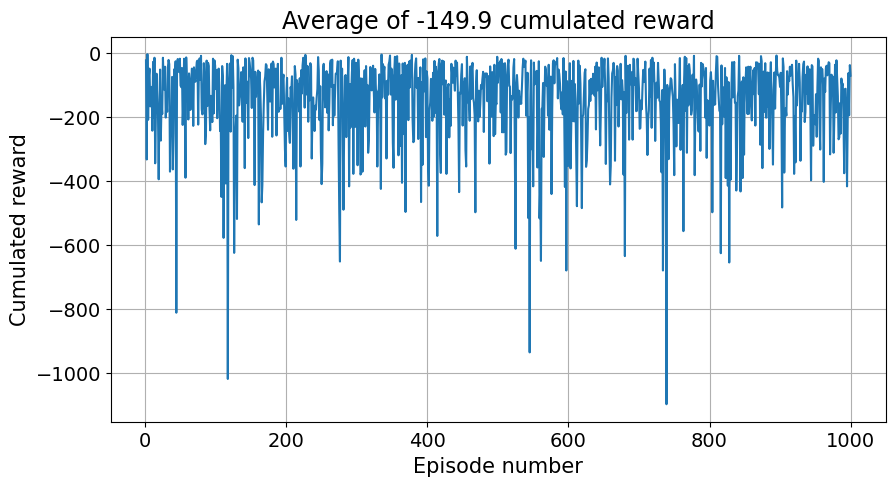

In [20]:
# Run this cell to see what you get for the gridworld you defined
%matplotlib inline
random_exploration_episodes(start, stop, state_index, 1000)

# Value function
What if instead of doing an average of many episodes, we could immediatey predict the future reward you expect by being in a particular state? This is where the value function and the Bellman equation enter the game.

The **value function** $v$ is a prediction of the expected future reward.
* It's used to evaluate how "good" being in a state is, which in turn helps the agent choose between states. It's value represents the amount of cumulated reward you are expecting to get from that state onwards.
* It works like a one-step lookahead tree, where you average all the possible outcomes together and get the value function at that particular state.

\begin{equation}
    v(s) = \mathcal{R_s} + \gamma \sum_{s'\in \mathcal{S}} \mathcal{P}_{ss'}v(s')
\end{equation}

where $s$ is the current state, $s'$ is a possible future state, and:

* $\mathcal{R}_s$ is the **reward function** (how much reward we get from state $s$ at that moment).
* $\mathcal{P}_{ss'}$ is the **state transition probability**: $\mathcal{P}_{ss'}=\mathbb{P}[\mathcal{S}_{t+1}=s'|\mathcal{S_t}=s]$ (probability of being in state $s'$ after being in state $s$).
* $\gamma$ is a discount factor $\gamma \in [0,1]$, usually used to make returns finite. In this example the return can be 1 since the process is not cyclic.

In [21]:
gamma = 1

# State-value function and the Bellman expectation equation
The value function depends on the way the agent is behaving, i.e. on the policy $v \rightarrow v_{\pi}$.
We define the **state-value function** $v_{\pi}$ as the expected return starting from state $s$ and then following policy $\pi$.
If we decompose it into immediate reward and discounted value of successor state we get the **Bellman expectation equation**:

\begin{equation}
    v_{\pi}(s) = \sum_{a \in \mathcal{A}} \pi(a|s)  \ (\mathcal{R^a_s} + \gamma \sum_{s'\in \mathcal{S}} \mathcal{P}^a_{ss'}v_{\pi}(s') )
\end{equation}


where $s$ is the current state, $s'$ is a possible future state, and:

* $\mathcal{R}^a_s$ is the **reward model** (expected reward through action $a$ after being in state $s$).
* $\mathcal{P}^a_{ss'}$ is the **state transition model**: $\mathcal{P}_{ss'}=\mathbb{P}[\mathcal{S}_{t+1}=s'|\mathcal{S_t}=s, \mathcal{A}=a]$ (probability of ending up in state $s'$ through action $a$ after being in state $s$).

In our case, every time the agent takes an action it will end up in the corresponding next state. This means that there is no uncertainty that by choosing the action 'up', the agent will go up. This might be different in other environments, but in this case $\mathcal{P}^a_{ss'}$ = 1.

# Solving the Bellman expectation equation exactly
The Bellman expectation equation given by Eq. (4) is a set of equations, which in the majority of situations cannot be explicitly solved. However, we are dealing with a very simple case where we can solve the equation exactly.
Doing that for the 4x4 example we get the following state-value function (image below).
Notice the value for state 0. Is it familiar? We actually got an approximation by averaging the total reward for 1000 episodes.

![](images/RandomPolicyValueFunction4x4.png)

In [22]:
# Functions to calculate and plot the value function
def value_function_equation(s, next_viable_state, policy, a, gamma):
    if s == stop:
        v1 = 0
    else:
        v1 = Symbol("v" + str(int(s)))

    if next_viable_state == stop:
        v2 = 0
    else:
        v2 = Symbol("v" + str(int(next_viable_state)))

    equation = policy[a] * get_reward(next_viable_state) + policy[a] * gamma * v2
    return v1, v2, equation


def get_value_function(states, actions, policy, gamma):
    equations = []
    variables = []
    guess = []
    for s in states[:-1]:
        right_side_equation = 0
        for a in actions:
            next_viable_state = step(s, a, state_index, all_states_grid)
            v1, v2, eq = value_function_equation(s, next_viable_state, policy, a, gamma)
            right_side_equation += eq

        new_equation = v1 - right_side_equation
        print(new_equation, "= 0")
        equations.append(new_equation)

        if v1 != 0:
            variables.append(v1)
        guess.append(random.uniform(-200, 200))
    #     variables.append(Symbol('v' + str(int(stop))))

    print(" ")
    print(len(variables), "variables, ", len(equations), "equations")

    solutions_exact = solve(equations)

    if len(solutions_exact) != 0:
        print(" ")
        sol_dict = {}
        sol_dict[str(stop)] = 0
        for i, j in zip(solutions_exact.keys(), solutions_exact.values()):
            sol_dict[str(i).strip("v")] = round(j, 1)
        return sol_dict

    else:
        print(" ")
        print("No exact solution, trying numerical solver")

        try:
            solutions_numerical = nsolve(equations, variables, guess, verify=False)
            print(" ")

            sol_dict = {}
            sol_dict[str(stop)] = 0
            for i, j in zip(variables, solutions_numerical):
                sol_dict[str(i).strip("v")] = round(j, 1)
            return sol_dict

        except ZeroDivisionError:
            print(" ")
            print("The numerical solver did not find a solution")


def plot_gridworld_value_function(rows, columns, blocks, solutions):
    counter_columns = -1
    counter_rows = 0

    row_grid_color = []
    all_states_grid_color = np.zeros([rows, columns])

    row_grid = []
    all_states_grid = np.zeros([rows, columns], dtype=int)

    row_grid_value = []
    all_states_grid_value = np.zeros([rows, columns])

    for s in range(0, rows * columns):
        counter_columns += 1
        if counter_columns < columns - 1:
            row_grid.append(s)
            if s in blocks:
                row_grid_color.append(0)
                row_grid_value.append(66)
            else:
                row_grid_color.append(0.5)
                try:
                    row_grid_value.append(solutions[str(int(s))])
                except KeyError:
                    row_grid_value.append(66)
        else:
            row_grid.append(s)
            if s in blocks:
                row_grid_color.append(0)
                row_grid_value.append(66)
            else:
                row_grid_color.append(0.5)
                try:
                    row_grid_value.append(solutions[str(int(s))])
                except KeyError:
                    row_grid_value.append(66)

            all_states_grid[counter_rows] = row_grid
            all_states_grid_color[counter_rows] = row_grid_color
            all_states_grid_value[counter_rows] = row_grid_value

            row_grid = []
            row_grid_color = []
            row_grid_value = []

            counter_columns = -1
            counter_rows += 1

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.imshow(
        all_states_grid_value,
        extent=[0, columns, rows, 0],
        cmap="hot",  # RdYlGn
        vmin=min(solutions.values()),
        vmax=max(solutions.values()) + 30,
    )

    ax.grid(color="black", linestyle="-", linewidth=5)
    ax.xaxis.set_ticklabels([])
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks_position("none")

    ax.set_xticks(np.arange(0, columns, step=1))
    ax.set_yticks(np.arange(0, rows, step=1))

    for i in range(0, rows):
        for j in range(0, columns):
            if all_states_grid_value[i, j] != 66:
                text = ax.text(
                    j + 0.3,
                    i + 0.4,
                    round(all_states_grid_value[i, j], 1),
                    ha="left",
                    va="top",
                    color="w",
                    size=13,
                )

    plt.show()

In [23]:
# Run this block to see the set of equations and the solutions for your gridworld
solutions = get_value_function(states, actions, policy, gamma)
print(solutions)

0.5*v0 - 0.25*v1 - 0.25*v4 + 1.0 = 0
-0.25*v0 + 0.5*v1 - 0.25*v5 + 1.0 = 0
0.25*v3 - 0.25*v7 + 1.0 = 0
-0.25*v0 + 0.75*v4 - 0.25*v5 - 0.25*v8 + 1.0 = 0
-0.25*v1 - 0.25*v4 + 0.75*v5 - 0.25*v6 + 1.0 = 0
-0.25*v10 - 0.25*v5 + 0.75*v6 - 0.25*v7 + 1.0 = 0
-0.25*v3 - 0.25*v6 + 0.5*v7 + 1.0 = 0
-0.25*v12 - 0.25*v4 + 0.5*v8 + 1.0 = 0
0.5*v10 - 0.25*v14 - 0.25*v6 + 1.0 = 0
0.25*v12 - 0.25*v8 + 1.0 = 0
-0.25*v10 + 0.5*v14 + 0.5 = 0
 
11 variables,  11 equations
 
{'15': 0, '0': -154.000000000000, '1': -150.000000000000, '10': -82.0000000000000, '12': -166.000000000000, '14': -42.0000000000000, '3': -130.000000000000, '4': -154.000000000000, '5': -142.000000000000, '6': -118.000000000000, '7': -126.000000000000, '8': -162.000000000000}


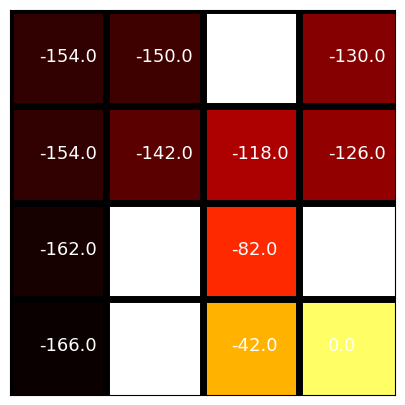

In [24]:
%matplotlib inline
# Run this cell to automatically generate the grid with the state-value function
plot_gridworld_value_function(rows, columns, blocks, solutions)